In [1]:
from operator import itemgetter
import os
from pathlib import Path
import re
import matplotlib.pyplot as plt
%matplotlib inline

FEDAVG_DIR = Path("../benchmark_results/fedavg")
FEDAVG_VARIANTS = FEDAVG_DIR / "variants"
FEDAVG_LR = FEDAVG_DIR / 'learning_rates'

# Verification plots

In [2]:
from collections import namedtuple
import csv
from itertools import repeat
import numpy as np
import math
import scipy.interpolate as inter
from statistics import mean

In [3]:
def read_verification_log(file_name):
    '''
    Read generated verification data from a csv file.

    Return: tuple of recorded errors and accuracies
    '''
    Errors = []
    Accs = []
    VerificationRecord = namedtuple('VerificationRecord', 'opt_error, accuracy')
    
    with open(file_name) as csvfile:
        readCSV = map(VerificationRecord._make, csv.reader(csvfile, delimiter=','))
        for row in readCSV:
            Errors.append(float(row.opt_error))
            Accs.append(float(row.accuracy))
    return (Errors, Accs)

    
# Smoothing as in TB: https://github.com/tensorflow/tensorflow/blob/905662a1c047f314ad295e27d2e2a00b4aa51e90/tensorflow/tensorboard/components/vz_line_chart/vz-line-chart.ts#L432
# Assume that we only have finite numbers.
def smooth_data(data, smoothing_weight=0.6):
    factor = ((1000** smoothing_weight) - 1) / 999
    kernel_radius = math.floor(len(data) * factor / 2)
    
    Y_smoothed = []
    
    for i, d in enumerate(data):
        actual_kernel_radius = min(kernel_radius, i, len(data) - i - 1)
        start = i - actual_kernel_radius
        end = i + actual_kernel_radius + 1
        
        Y_smoothed.append(mean(data[start:end]))
    
    return Y_smoothed


def plot_progress(X, Y, title='', ymax=1, ymin=0, ylabel=''):
    plt.ylim(ymin, ymax)
    plt.plot(X, Y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Communication round')
    #plt.legend(['test'], loc='upper right')
    plt.show()

    
def interpolate_spline(X,Y, spacing, smoothing=0.0):
    s1 = inter.UnivariateSpline(X, Y, s=smoothing)
    xNew = np.linspace(min(X),max(X),spacing)
    return xNew, s1(xNew)


def monotone_progress(Accs):
    maximum = 0
    monotoneValues = []
    for acc in Accs:
        maximum = maximum if acc < maximum else acc
        monotoneValues.append(maximum)
    return monotoneValues
        

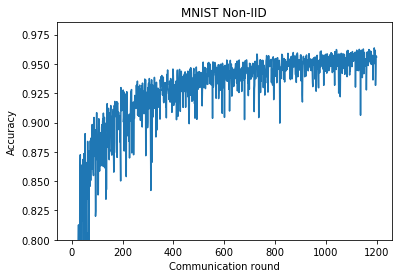

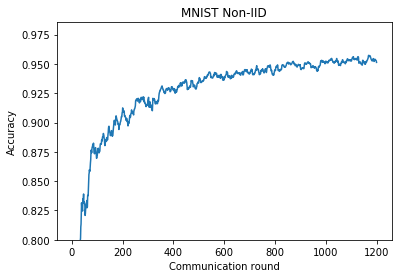

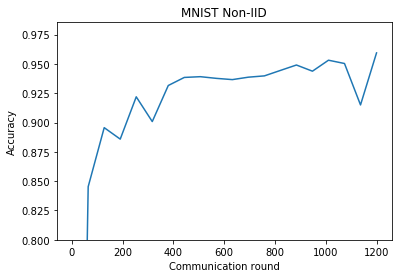

In [4]:
verification_file = FEDAVG_VARIANTS / 'verification_log_MNIST_nonIID_2NN_C10_E5_B10_LR0.01_variant1.csv'

Errs, Accs = read_verification_log(verification_file)
Rounds = list(range(1,len(Errs)+1))

smoothing = 0.2
Accs_smooth = smooth_data(Accs, smoothing)
Errs_smooth = smooth_data(Errs, smoothing)

X_range = Rounds[0:1200]
Acc_range = Accs[0:1200] 

smoothing = 0.08
X_interpolated, Accs_interpolated = interpolate_spline(X_range, Acc_range, 20, smoothing)

# Plot them!
title = 'MNIST Non-IID'
ylabel = 'Accuracy'
ymax = max(Accs)+0.01
ymin = 0.80

plot_progress(X_range, Acc_range, title, ymax, ymin, ylabel)
plot_progress(X_range, Accs_smooth[0:1200], title, ymax, ymin, ylabel)
plot_progress(X_interpolated, Accs_interpolated, title, ymax, ymin, ylabel)

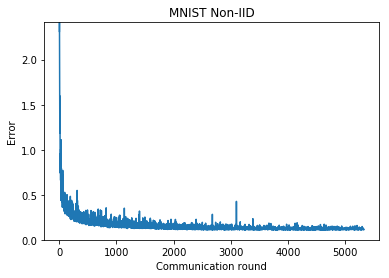

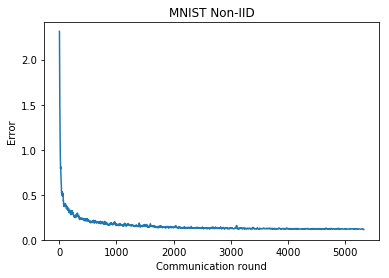

In [5]:
ylabel = 'Error'
ymax = max(Errs)

plot_progress(Rounds, Errs, title, ymax, ylabel=ylabel)
plot_progress(Rounds, Errs_smooth, title, ymax, ylabel=ylabel)

In [6]:
print(max(list(zip(Accs, Rounds)))) # Last communication round with the maxuimum accuracy
print(max(list(zip(Accs, Rounds)),  key=itemgetter(0))) # First communication round with the maximum accuracy

(0.9754, 5326)
(0.9754, 4441)


## Plot all variants

In [7]:
def plot_progress_3(x1, y1, title1,
                    x2, y2, title2,
                    x3, y3, title3,
                    ymax=1, ymin=0, ylabel=''):

    min_len = min(len(x1), len(x2), len(x3))
    # x1 = x1[:min_len]
    # x2 = x2[:min_len]
    # x3 = x3[:min_len]
    # y1 = y1[:min_len]
    # y2 = y2[:min_len]
    # y3 = y3[:min_len]

    fig, axs = plt.subplots(1,3,figsize=(15,5))
    xlabel = 'Communication round'

    axs[0].set_title(title1)
    axs[0].set_ylabel(ylabel)
    axs[0].set_xlabel(xlabel)
    axs[0].set_ylim(ymin, ymax)

    axs[0].plot(x1, y1, 'c')

    axs[1].set_title(title2)
    axs[1].set_ylabel(ylabel)
    axs[1].set_xlabel(xlabel)
    axs[1].set_ylim(ymin, ymax)

    axs[1].plot(x2, y2, 'm')
    
    axs[2].set_title(title3)
    axs[2].set_ylabel(ylabel)
    axs[2].set_xlabel(xlabel)
    axs[2].set_ylim(ymin, ymax)

    axs[2].plot(x3, y3, 'y')


def plot_on_plots(x1, y1,
                  x2, y2,
                  x3, y3, title,
                  ymax=1, ymin=0, ylabel=''):

    min_len = min(len(x1), len(x2), len(x3))
    x1 = x1[:min_len]
    x2 = x2[:min_len]
    x3 = x3[:min_len]
    y1 = y1[:min_len]
    y2 = y2[:min_len]
    y3 = y3[:min_len]

    plt.ylim(ymin, ymax)
    var1, = plt.plot(x2, y2, 'k', label='variant 1')
    var0, = plt.plot(x1, y1, 'r', label='variant 0')
    var2, = plt.plot(x3, y3, 'y', label='variant 2')
    var0Monotone = plt.plot(x2, monotone_progress(y2), color='lightgray', alpha=0.8)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Communication round')
    plt.legend(handles=[var0, var1, var2])

    pdf_path = "../benchmark_results/plot_" + title.replace(' ', '_') + ".pdf"
    plt.savefig(pdf_path, format='pdf')    
    plt.show()

Var0 len = 7588
Var1 len = 7246
Var2 len = 6021


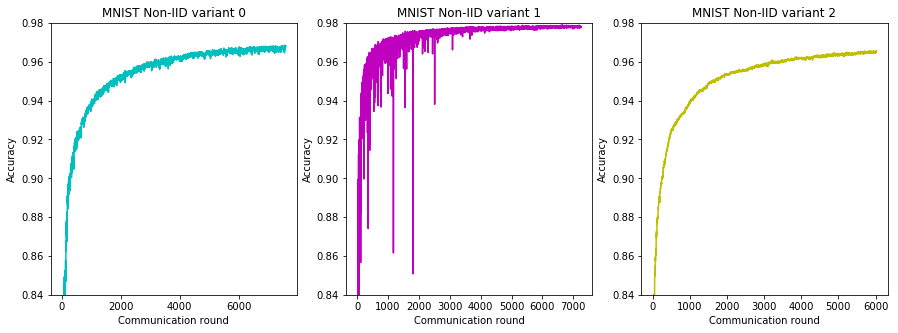

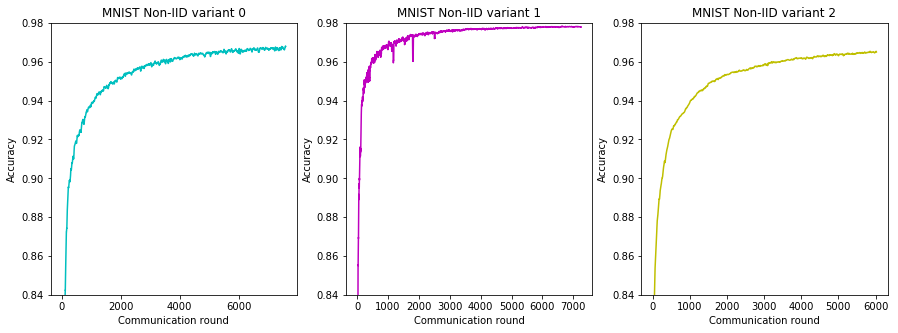

In [8]:
title1 = 'MNIST Non-IID variant 0'
title2 = 'MNIST Non-IID variant 1'
title3 = 'MNIST Non-IID variant 2'

verification_file0 = FEDAVG_VARIANTS / 'verification_log_MNIST_nonIID_2NN_C10_E5_B20_LR0.05_Decay1e-5_variant0.csv'
verification_file1 = FEDAVG_VARIANTS / 'verification_log_MNIST_nonIID_2NN_C10_E5_B20_LR0.05_Decay1e-5_variant1.csv'
verification_file2 = FEDAVG_VARIANTS / 'verification_log_MNIST_nonIID_2NN_C10_E5_B20_LR0.05_Decay1e-5_variant2.csv'

Errs0, Accs0 = read_verification_log(verification_file0)
n_samples0 = len(Accs0)
Rounds0 = list(range(1,n_samples0+1))
print("Var0 len = " + str(n_samples0))

Errs1, Accs1 = read_verification_log(verification_file1)
n_samples1 = len(Accs1)
Rounds1 = list(range(1,n_samples1+1))
print("Var1 len = " + str(n_samples1))

Errs2, Accs2 = read_verification_log(verification_file2)
n_samples2 = len(Accs2)
Rounds2 = list(range(1,n_samples2+1))
print("Var2 len = " + str(n_samples2))

ylabel = 'Accuracy'
ymax = 0.98 #max(max(Accs0), max(Accs1), max(Accs2))
ymin = 0.84
n_com_rounds = min(n_samples0, n_samples1, n_samples2)
Rounds = list(range(1,max(n_samples0, n_samples1, n_samples2)+1))

smoothing = 0.2
Accs_smooth0 = smooth_data(Accs0, smoothing)
Errs_smooth0 = smooth_data(Errs0, smoothing)
Accs_smooth1 = smooth_data(Accs1, smoothing)
Errs_smooth1 = smooth_data(Errs1, smoothing)
Accs_smooth2 = smooth_data(Accs2, smoothing)
Errs_smooth2 = smooth_data(Errs2, smoothing)

X_range0 = Rounds[:n_samples0]
X_range1 = Rounds[:n_samples1]
X_range2 = Rounds[:n_samples2]

plot_progress_3(X_range0, Accs0, title1, X_range1, Accs1, title2, X_range2, Accs2, title3, ymax, ymin, ylabel)
plot_progress_3(X_range0, Accs_smooth0, title1, X_range1, Accs_smooth1, title2, X_range2, Accs_smooth2, title3, ymax, ymin, ylabel)


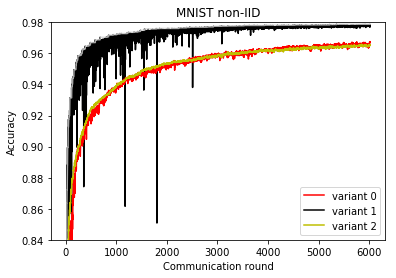

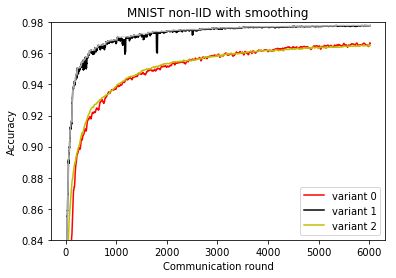

In [9]:
title = 'MNIST non-IID'
plot_on_plots(X_range0, Accs0, X_range1, Accs1, X_range2, Accs2, title, ymax, ymin, ylabel)
title_smooth = 'MNIST non-IID with smoothing'
plot_on_plots(X_range0, Accs_smooth0, X_range1, Accs_smooth1, X_range2, Accs_smooth2, title_smooth, ymax, ymin, ylabel)

# Parameter Search -  Learning Rate $\eta$

In [10]:
def simple_plot_progress(Y, title='', ymax=1, ymin=0, ylabel=''):
    plt.ylim(ymin, ymax)
    plt.plot(Y)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel('Communication round')
    plt.show()
    
def plot_overlap(*ys, **kwargs):

    fig = plt.figure(figsize=(5,5),facecolor = 'wheat', dpi=200)
    min_len = min([len(y) for y in ys])
    for y in ys:
        y = y[:min_len]
        plt.plot(y)
    
    if 'ymin' in kwargs:
        ymin = kwargs['ymin']
        ymax = max([max(y) for y in ys])
        plt.ylim(ymin, ymax)

    plt.ylabel("Accuracy")
    plt.xlabel("Communication round")
    plt.legend(range(len(ys)), loc='lower right')
    plt.show(fig)

1281 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.09.csv
Max accuracy: 0.9307


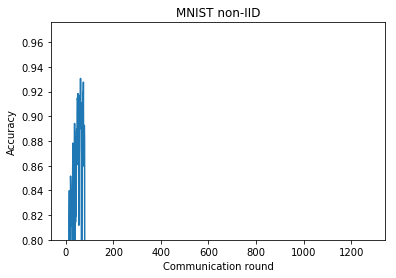

1281 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.08.csv
Max accuracy: 0.9755


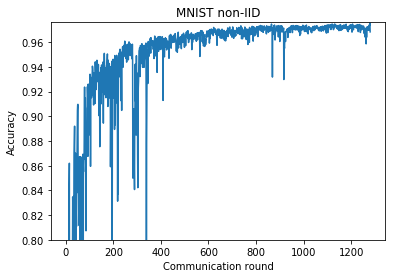

1281 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.07.csv
Max accuracy: 0.9759


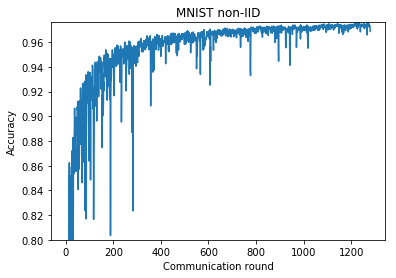

1281 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.06.csv
Max accuracy: 0.9761


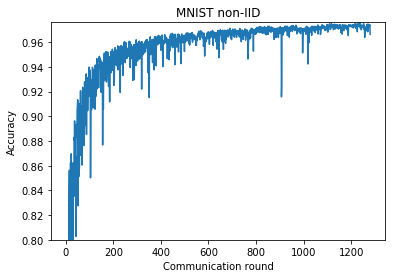

1281 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.05.csv
Max accuracy: 0.9738


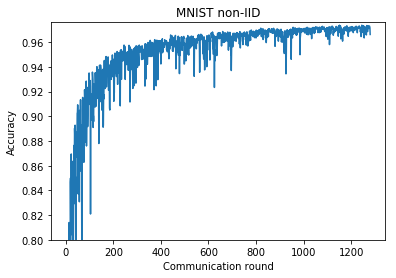

1281 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.04.csv
Max accuracy: 0.973


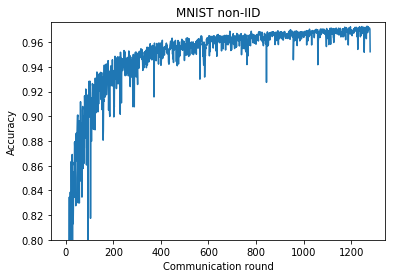

1280 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.037037037037037035.csv
Max accuracy: 0.9727


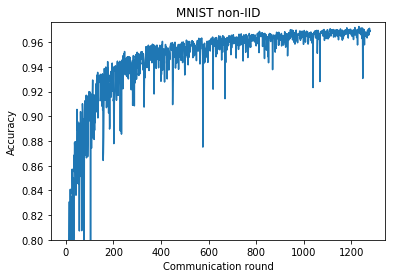

1281 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.03.csv
Max accuracy: 0.9699


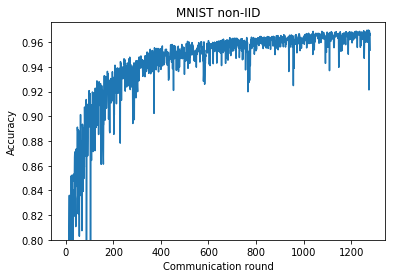

1281 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.02.csv
Max accuracy: 0.9646


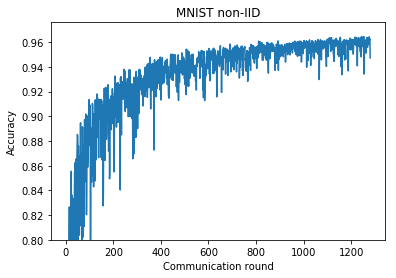

1280 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.012345679012345678.csv
Max accuracy: 0.9586


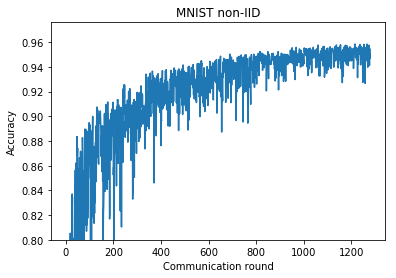

1280 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.00411522633744856.csv
Max accuracy: 0.9419


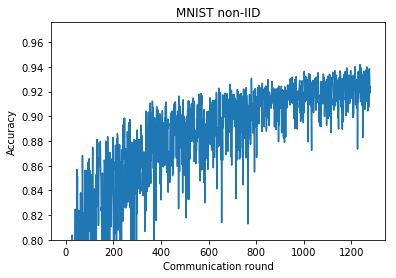

1280 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.0013717421124828531.csv
Max accuracy: 0.9192


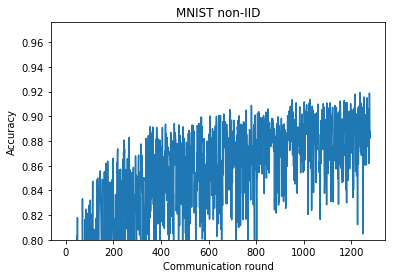

1277 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.0004572473708276177.csv
Max accuracy: 0.9087


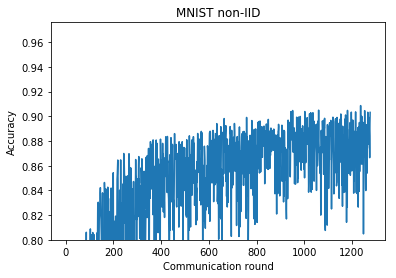

1275 C.R. in ../benchmark_results/fedavg/learning_rates/verification_log_lr_0.00015241579027587258.csv
Max accuracy: 0.9052


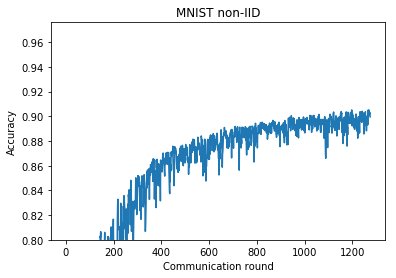

In [11]:
import glob

verification_reg =  str(FEDAVG_LR  / 'verification_log_lr_*.csv')
verification_files = sorted(glob.glob(verification_reg), reverse=True)
accss = [(read_verification_log(file)[1], file) for file in verification_files ]

ylabel = 'Accuracy'
ymax = max([max(accs) for accs,_ in accss])
ymin = 0.80

for (accs, file_name) in accss:
    n_samples = len(accs)
    max_val = max(accs)
    print("{:d} C.R. in {}".format(n_samples, file_name))
    print("Max accuracy: {}".format(max_val))

    simple_plot_progress(accs, 'MNIST non-IID', ymax, ymin, ylabel)


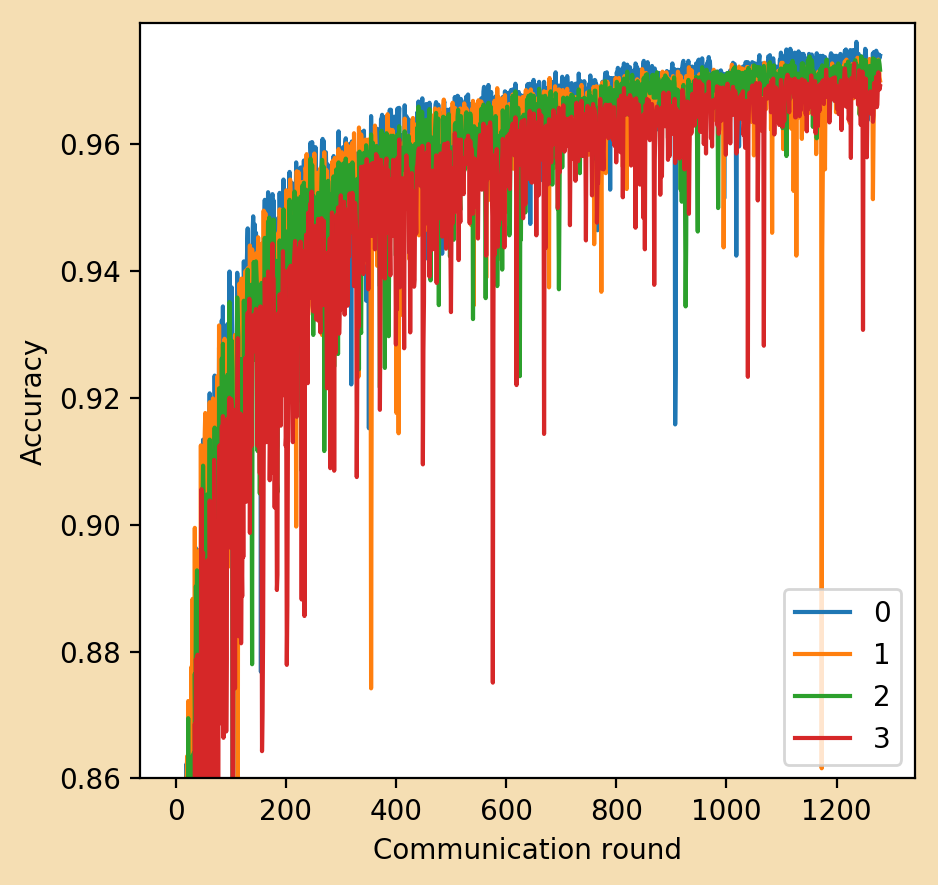

In [12]:
verification_files = [
    FEDAVG_LR / 'verification_log_lr_0.06.csv',
    FEDAVG_VARIANTS / 'verification_log_MNIST_nonIID_2NN_C10_E5_B20_LR0.05_Decay1e-5_variant1.csv',
    FEDAVG_LR / 'verification_log_lr_0.05.csv',
    FEDAVG_LR / 'verification_log_lr_0.037037037037037035.csv',
    ]
accs = [read_verification_log(file)[1] for file in verification_files]

plot_overlap(*accs, ymin=0.86)